<p style="border: 1px solid #e7692c; border-left: 15px solid #e7692c; padding: 10px; text-align:justify;">
    <strong style="color: #e7692c">Tip.</strong> <a style="color: #000000;" href="https://nbviewer.jupyter.org/github/PacktPublishing/Hands-On-Computer-Vision-with-Tensorflow/blob/master/ch4/ch4_nb3_fetch_models_from_tf_hub.ipynb" title="View with Jupyter Online">Click here to view this notebook on <code>nbviewer.jupyter.org</code></a>. 
    <br/>These notebooks are better read there, as Github default viewer ignores some of the formatting and interactive content.
    </p>

<table style="font-size: 1em; padding: 0; margin: 0;">
    <tr style="vertical-align: top; padding: 0; margin: 0;background-color: #ffffff">
        <td style="vertical-align: top; padding: 0; margin: 0; padding-right: 15px;">
    <p style="background: #363636; color:#ffffff; text-align:justify; padding: 10px 25px;">
        <strong style="font-size: 1.0em;"><span style="font-size: 1.2em;"><span style="color: #e7692c;">Hands-on</span> Computer Vision with TensorFlow 2</span><br/>by <em>Eliot Andres</em> & <em>Benjamin Planche</em> (Packt Pub.)</strong><br/><br/>
        <strong>> Chapter 4: Influential Classification Tools</strong><br/>
    </p>

<h1 style="width: 100%; text-align: left; padding: 0px 25px;"><small style="color: #e7692c;">
    Notebook 3:</small><br/>Fetching Models from TensorFlow Hub</h1>
<br/>
<p style="border-left: 15px solid #363636; text-align:justify; padding: 0 10px;">
    In the introductory chapter of the book, we presented what <em>computer vision</em> and <em>deep learning</em> are, and how <em>neural</em> networks work. To illustrate the latter, we described how to <strong>build a simple neural network from scratch</strong>, and how to <strong>apply it to a classification task</strong>.
    <br/><br/>In this first notebook, we will therefore detail the related code snippets and results from the book.
</p>
<br/>
<p style="border-left: 15px solid #e7692c; padding: 0 10px; text-align:justify;">
    <strong style="color: #e7692c;">Tip.</strong> The notebooks shared on this git repository illustrate some notions from the book "<em><strong>Hands-on Computer Vision with TensorFlow 2</strong></em>" written by Eliot Andres and Benjamin Planche, published by Packt. If you enjoyed the insights shared here, <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!"><strong>please consider acquiring the book!</strong></a>
<br/><br/>
The book provides further guidance for those eager to learn about computer vision and to harness the power of TensorFlow 2 and Keras to build efficient recognition systems for object detection, segmentation, video processing, smartphone applications, and more.</p>
        </td>
        <td style="vertical-align: top; padding: 0; margin: 0; width: 280px;">
    <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!" target="_blank">
        <img src="../banner_images/book_cover.png" width=280>
    </a>
    <p style="background: #e7692c; color:#ffffff; padding: 10px; text-align:justify;"><strong>Leverage deep learning to create powerful image processing apps with TensorFlow 2 and Keras. <br/></strong>Get the book for more insights!</p>
    <ul style="height: 32px; white-space: nowrap; text-align: center; margin: 0px; padding: 0px; padding-top: 10px;">
    <li style="display: block;height: 100%;float: left;vertical-align: middle;margin: 0 25px 10px;padding: 0px;">
        <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Get the book on Amazon (paperback or Kindle version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_amazon.png" width="75px">
        </a>
    </li>
    <li style="display: inline-block;height: 100%;vertical-align: middle;float: right;margin: -5px 25px 10px;padding: 0px;">
        <a href="https://www.packtpub.com/application-development/hands-computer-vision-tensorflow-2" title="Get your Packt book (paperback, PDF, ePUB, or MOBI version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_packt.png" width="75px">
        </a>
    </li>
    </ul>
        </td>
        </tr>
        </table>

In [ ]:
# !pip install tensorflow-hub   # Uncomment to install the module (tensorflow-hub>0.3 required)

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import os
from matplotlib import pyplot as plt
import math

# Some hyper-parameters:
batch_size  = 32            # Images per batch (reduce/increase according to the machine's capability)
num_epochs  = 300           # Max number of training epochs
random_seed = 42            # Seed for some random operations, for reproducibility

## Preparing the Data

Again, to directly compare with the results from the [previous notebooks](./ch4_nb1_implement_resnet_from_scratch.ipynb), we will apply our model to the classification of the benchmark dataset_CIFAR-100_, collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton[$^1$](#ref).

We will reuse the input pipelines previously defined:

In [2]:
# !pip install tensorflow-datasets # Uncomment to install the module
import cifar_utils

cifar_info = cifar_utils.get_info()
print(cifar_info)

# Number of classes:
num_classes = cifar_info.features['label'].num_classes

# Number of images:
num_train_imgs = cifar_info.splits['train'].num_examples
num_val_imgs = cifar_info.splits['test'].num_examples

train_steps_per_epoch = math.ceil(num_train_imgs / batch_size)
val_steps_per_epoch   = math.ceil(num_val_imgs / batch_size)

tfds.core.DatasetInfo(
    name='cifar100',
    version=1.3.1,
    description='This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).',
    urls=['https://www.cs.toronto.edu/~kriz/cifar.html'],
    features=FeaturesDict({
        'coarse_label': ClassLabel(shape=(), dtype=tf.int64, num_classes=20),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=100)
    },
    total_num_examples=60000,
    splits={
        'test': <tfds.core.SplitInfo num_examples=10000>,
        'train': <tfds.core.SplitInfo num_examples=50000>
    },
    supervised_keys=('image', 'label'),
    citation='"""
        @TECHREPORT{Krizhevsky09learning

## Fetching and Training TF Hub Models

In Chapter 4, we explained how TF Hub can be called to fetch a pre-defined feature extractor, and how to build a classification model around.


### Building an Inception Classifier with TF Hub

For example, a classification network for Tiny-ImageNet based on the Inception architecture can be created with TF Hub as follow. First, we need to search the TF Hub catalog ([https://tfhub.dev](https://tfhub.dev)) to find a satisfying module. We will opt first for a *Inception V3[$^2$](#ref) feature extractor* model (i.e., an _Inception_ model with its final classification layers removed c.f. Chapter 4).

Searching TF Hub website, we can easily find such a model: "[https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2](https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2)" (Inception V3 model pre-trained on ImageNet). We can use the link to the model's page to define and initialize it:

In [3]:
# model_url = "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1"

# We need a TF2-compatible model:
module_url = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2"
inception_expected_input_shape = [299, 299, 3]
inception_expected_output_shape = [2048]

With the latest versions of `tensorflow-hub`, one can directly fetch the model and its pre-trained weights from TF Hub and instantiate the model as a Keras layer in a single command:

In [4]:
hub_feature_extractor = hub.KerasLayer(
    module_url, 
    trainable=False,                              # Flag to set the layers as trainable or not
    input_shape=inception_expected_input_shape,   # Expected input shape.
    output_shape=inception_expected_output_shape, # Output shape [batch_size, 2048].
    dtype=tf.float32)                             # Expected dtype

# Note: These parameters can be found on the webpage of tfhub Module, or can be fetched as follows:
# module_spec = hub.load_module_spec(model_url)
# expected_height, expected_width = hub.get_expected_image_size(module_spec)
# expected_input_shape = tf.convert_to_tensor([height, width, 3])

print(hub_feature_extractor)

This layer can then be used like any other. As presented in the book, we can append to it new fully-connected layers leading the the predictions for our different task (recognition on _CIFAR_):

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

inception_model = Sequential([
    hub_feature_extractor,
    Dense(num_classes, activation='softmax', name="logits_pred")
], name="inception_tf_hub")   

In [6]:
inception_model.summary()

Model: "inception_tf_hub"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
logits_pred (Dense)          (None, 100)               204900    
Total params: 22,007,684
Trainable params: 204,900
Non-trainable params: 21,802,784
_________________________________________________________________


With that, we have an Inception model ready, with its main layers already pre-trained on the complex _ImageNet_ dataset.

As we can observe from the summary printed above, as we set `trainable=False` when calling `hub.KerasLayer()`, all the parameters of the pre-trained feature extractor are fixed as _**non-trainable/frozen**_. In the following section, we will demonstrate how by only training the final dense layer, we can still obtain a performant _CIFAR_ classifier thanks to transfer learning.

***Note:*** In Chapter 3 and in [one of the related notebooks](../ch3/ch3_nb4_apply_regularization_methods_to_cnns.ipynb), we presented regularization methods, and how secondary losses can be attached to layers to regularize/constrain them during training. If we check the implementation of the _Inception V3_ we just fetched from TF Hub ([https://github.com/tensorflow/models/blob/master/research/slim/nets/inception_v3.py](https://github.com/tensorflow/models/blob/master/research/slim/nets/inception_v3.py)), we can see that some of those regularization methods are applied to it. Furthermore, if we check the model's `.losses` (c.f. Chapter 3), it seems that some of these secondary losses have been attached to it. 

In theory, it would be recommended to retrain/fine-tune layers like `BatchNorm`, though we will ignore thisfor the current notebook. More refined transfer learning and fine-tuning will be presented in the [next notebook](ch4_nb4_apply_transfer_learning.ipynb).

In [7]:
inception_model.losses

[<tf.Tensor: id=16230, shape=(), dtype=float32, numpy=0.2279525>]

### Training the TF Hub Inception Classifier

Once again, as our model is now like any other Keras models, we will reuse our utility methods from the previous notebooks to train it for our task.

In [9]:
# Datasets:
train_cifar_dataset = cifar_utils.get_dataset(
    phase='train', batch_size=batch_size, num_epochs=num_epochs, shuffle=True,
    input_shape=inception_expected_input_shape, seed=random_seed)

val_cifar_dataset = cifar_utils.get_dataset(
    phase='test', batch_size=batch_size, num_epochs=1, shuffle=False,
    input_shape=inception_expected_input_shape, seed=random_seed)

In [10]:
import collections
import functools
from keras_custom_callbacks import SimpleLogCallback

metrics_to_print = collections.OrderedDict([("loss", "loss"), 
                                            ("v-loss", "val_loss"),
                                            ("acc", "acc"), 
                                            ("v-acc", "val_acc"),
                                            ("top5-acc", "top5_acc"), 
                                            ("v-top5-acc", "val_top5_acc")])

model_dir = './models/inception_tf_hub'
callbacks = [
    # Callback to interrupt the training if the validation loss/metrics stops improving for some epochs:
    tf.keras.callbacks.EarlyStopping(patience=8, monitor='val_acc',
                                     restore_best_weights=True),
    # Callback to log the graph, losses and metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir=model_dir, histogram_freq=0, write_graph=True),
    # Callback to simply log metrics at the end of each epoch (saving space compared to verbose=1/2):
    SimpleLogCallback(metrics_to_print, num_epochs=num_epochs, log_frequency=1)
]

# Compile:
inception_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top5_acc')
    ])

# Train
history = inception_model.fit(
    train_cifar_dataset,  epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
    validation_data=val_cifar_dataset, validation_steps=val_steps_per_epoch,
    verbose=0, callbacks=callbacks)

Training: start.
Epoch  0/300: loss = 2.993; v-loss = 2.301; acc = 0.334; v-acc = 0.467; top5-acc = 0.618; v-top5-acc = 0.755
Epoch  1/300: loss = 2.444; v-loss = 2.164; acc = 0.436; v-acc = 0.496; top5-acc = 0.726; v-top5-acc = 0.785
Epoch  2/300: loss = 2.324; v-loss = 2.095; acc = 0.462; v-acc = 0.511; top5-acc = 0.753; v-top5-acc = 0.794
Epoch  3/300: loss = 2.268; v-loss = 2.080; acc = 0.471; v-acc = 0.510; top5-acc = 0.763; v-top5-acc = 0.803
Epoch  4/300: loss = 2.216; v-loss = 2.080; acc = 0.486; v-acc = 0.521; top5-acc = 0.772; v-top5-acc = 0.803
Epoch  5/300: loss = 2.191; v-loss = 2.020; acc = 0.489; v-acc = 0.533; top5-acc = 0.778; v-top5-acc = 0.807
Epoch  6/300: loss = 2.153; v-loss = 2.036; acc = 0.497; v-acc = 0.529; top5-acc = 0.784; v-top5-acc = 0.806
Epoch  7/300: loss = 2.141; v-loss = 2.002; acc = 0.497; v-acc = 0.537; top5-acc = 0.788; v-top5-acc = 0.814
Epoch  8/300: loss = 2.118; v-loss = 1.996; acc = 0.505; v-acc = 0.535; top5-acc = 0.789; v-top5-acc = 0.813
Ep

Thanks to the callbacks we defined, we can follow the training either through the console logs or in Tensorboard (launched with `tensorboard --logdir ./models`, and accessed on [localhost:6006](localhost:6006)), c.f. following screenshot:

![Tensorboard screenshot](./notebook_images/tf_hub_tensorboard_training.png)

Though our estimator may not have completely converged yet, we can observe how fast it reached high validation accuracy, thanks to transfer learning.

### Predicting with the Inception Classifier

Once again reusing the functions implemented in the pevious notebook, as well as the test pictures presented there, let us have a look at how our new model performs on completely different images:

In [11]:
import glob
import numpy as np
from classification_utils import load_image, process_predictions, display_predictions

test_filenames = glob.glob(os.path.join('res', '*'))
test_images = np.asarray([load_image(file, size=inception_expected_input_shape[:2]) 
                          for file in test_filenames])
print('Test Images: {}'.format(test_images.shape))

image_batch = test_images[:16]

# Our model was trained on CIFAR images, which originally are 32x32px. We scaled them up
# to 224x224px to train our model on, but this means the resulting images had important
# artifacts/low quality.
# To test on images of the same quality, we first resize them to 32x32px, then to the 
#expected input size (i.e., 224x224px):
cifar_original_image_size = cifar_info.features['image'].shape[:2]
class_readable_labels = cifar_info.features["label"].names

Test Images: (16, 299, 299, 3)


Inception Predictions:


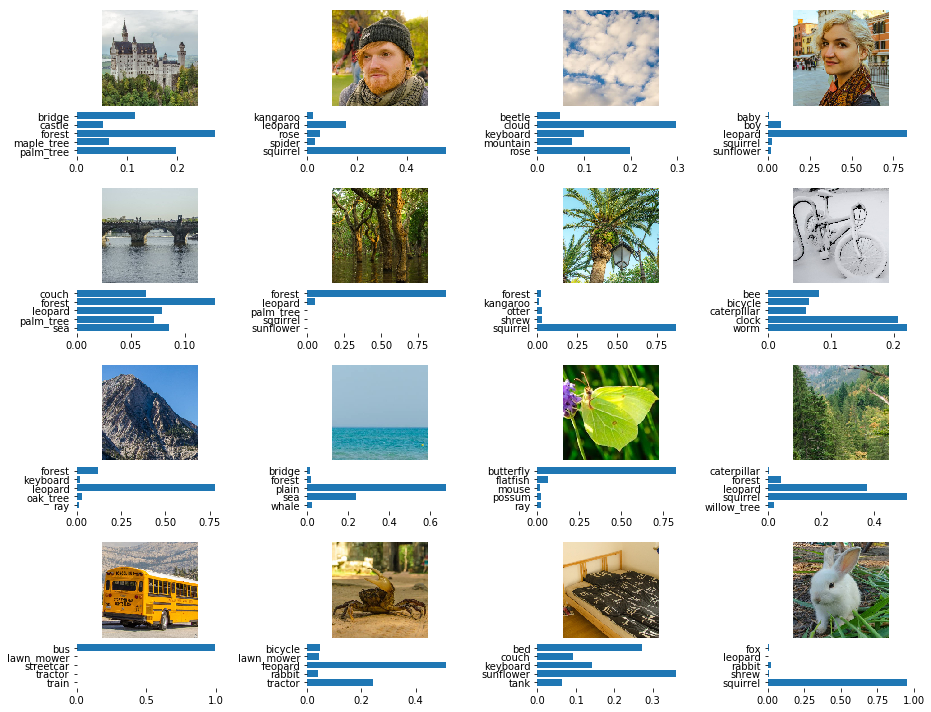

In [12]:
image_batch_low_quality = tf.image.resize(image_batch, cifar_original_image_size)
image_batch_low_quality = tf.image.resize(image_batch_low_quality, inception_expected_input_shape[:2])
    
predictions = inception_model.predict_on_batch(image_batch_low_quality)
top5_labels, top5_probabilities = process_predictions(predictions, class_readable_labels)

print("Inception Predictions:")
display_predictions(image_batch, top5_labels, top5_probabilities)

### Playing with Other TF Hub Models

The procedure we just presented can easily be applied to different models hosted on TensorFlow Hub.

We planned to demonstrate this by instantiating a _ResNet_ model[$^3$](#ref) from there, but alas none compatible with TensorFlow 2 have been shared yet. Therefore, we will instead repeat the exact same experiment but with a _MobileNet_ network[$^4$](#ref) (c.f. Chapter 9), by only changing the `model_url`:

In [13]:
# MobileNet V2 is a family of neural network architectures for efficient on-device image classification 
# and related tasks, originally published by Mark Sandler, Andrew Howard, Menglong Zhu, 
# Andrey Zhmoginov, Liang-Chieh Chen: "Inverted Residuals and Linear Bottlenecks: Mobile Networks
# for Classification, Detection and Segmentation", 2018.
model_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
model_dir = './models/mobilenet_tf_hub'
mobilenet_expected_input_shape = [224, 224, 3]
mobilenet_expected_output_shape = [2048]
# ^ The doc says [1280] though it results in an exception. Probably an error.

# Reset datasets (for proper resizing):
train_cifar_dataset = cifar_utils.get_dataset(
    phase='train', batch_size=batch_size, num_epochs=num_epochs, shuffle=True,
    input_shape=mobilenet_expected_input_shape, seed=random_seed)

val_cifar_dataset = cifar_utils.get_dataset(
    phase='test', batch_size=batch_size, num_epochs=1, shuffle=False,
    input_shape=mobilenet_expected_input_shape, seed=random_seed)

# Build:
hub_feature_extractor = hub.KerasLayer(
    module_url, 
    trainable=False,                              # Flag to set the layers as trainable or not
    input_shape=mobilenet_expected_input_shape,   # Expected input shape
    output_shape=mobilenet_expected_output_shape, # Output shape
    dtype=tf.float32)                             # Expected dtype
mobilenet_model = Sequential([
    hub_feature_extractor,
    Dense(num_classes, activation='softmax', name="logits_pred")
], name="mobilenet_tf_hub") 

# Compile:
mobilenet_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top5_acc')
    ])

# Train
callbacks = [
    # Callback to interrupt the training if the validation loss/metrics stops improving for some epochs:
    tf.keras.callbacks.EarlyStopping(patience=8, monitor='val_acc',
                                     restore_best_weights=True),
    # Callback to log the graph, losses and metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir=model_dir, histogram_freq=0, write_graph=True),
    # Callback to simply log metrics at the end of each epoch (saving space compared to verbose=1/2):
    SimpleLogCallback(metrics_to_print, num_epochs=num_epochs, log_frequency=1)
]
history_mobilenet = mobilenet_model.fit(
    train_cifar_dataset,  epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
    validation_data=val_cifar_dataset, validation_steps=val_steps_per_epoch,
    verbose=0, callbacks=callbacks)

Training: start.
Epoch  0/300: loss = 2.987; v-loss = 2.222; acc = 0.345; v-acc = 0.490; top5-acc = 0.619; v-top5-acc = 0.779
Epoch  1/300: loss = 2.480; v-loss = 2.143; acc = 0.434; v-acc = 0.507; top5-acc = 0.727; v-top5-acc = 0.794
Epoch  2/300: loss = 2.384; v-loss = 2.108; acc = 0.454; v-acc = 0.519; top5-acc = 0.745; v-top5-acc = 0.801
Epoch  3/300: loss = 2.328; v-loss = 2.115; acc = 0.466; v-acc = 0.517; top5-acc = 0.754; v-top5-acc = 0.797
Epoch  4/300: loss = 2.294; v-loss = 2.060; acc = 0.472; v-acc = 0.530; top5-acc = 0.762; v-top5-acc = 0.807
Epoch  5/300: loss = 2.274; v-loss = 2.074; acc = 0.478; v-acc = 0.531; top5-acc = 0.766; v-top5-acc = 0.806
Epoch  6/300: loss = 2.253; v-loss = 2.032; acc = 0.485; v-acc = 0.538; top5-acc = 0.770; v-top5-acc = 0.817
Epoch  7/300: loss = 2.220; v-loss = 2.073; acc = 0.490; v-acc = 0.533; top5-acc = 0.776; v-top5-acc = 0.809
Epoch  8/300: loss = 2.215; v-loss = 2.029; acc = 0.495; v-acc = 0.542; top5-acc = 0.776; v-top5-acc = 0.818
Ep

Again, we can follow the training both through the console logs or in Tensorboard. The latter makes it straightforward to visually compare the trainings of the different models.

Let us check how this model performs on our test images:

MobileNet Predictions:


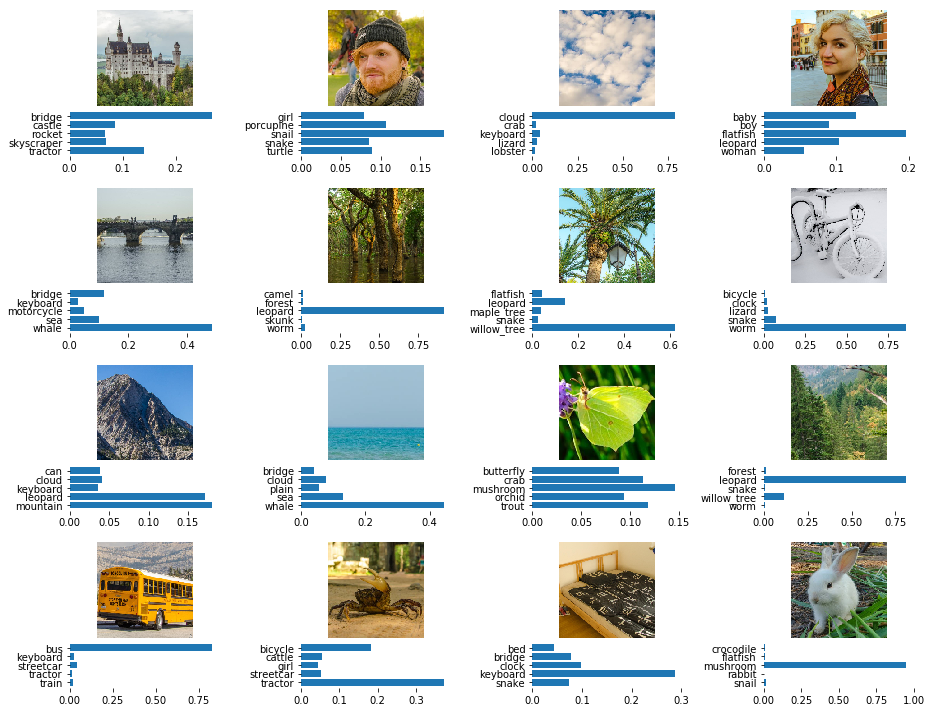

In [16]:
image_batch_low_quality = tf.image.resize(image_batch, cifar_original_image_size)
image_batch_low_quality = tf.image.resize(image_batch_low_quality, mobilenet_expected_input_shape[:2])
    
predictions = mobilenet_model.predict_on_batch(image_batch_low_quality)
top5_labels, top5_probabilities = process_predictions(predictions, class_readable_labels)

print("MobileNet Predictions:")
display_predictions(image_batch, top5_labels, top5_probabilities)

## Conclusion

To summarize, we just learned how to use together TensorFlow Hub and Keras to build powerful models reusing architectures and trained weights shared by the community. We saw how these models can be configured, trained, and used in production.

<a id="ref"></a>
#### References

1. Krizhevsky, A., Hinton, G. "*Learning multiple layers of features from tiny images*" (2009), Citeseer.
2. Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J. and Wojna, Z., 2016. Rethinking the inception architecture for computer vision. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2818-2826).
3. He, K., Zhang, X., Ren, S., Sun, J., 2015. Deep Residual Learning for Image Recognition. arXiv:1512.03385 [cs].
4. Howard, A.G., Zhu, M., Chen, B., Kalenichenko, D., Wang, W., Weyand, T., Andreetto, M. and Adam, H., 2017. Mobilenets: Efficient convolutional neural networks for mobile vision applications. arXiv preprint arXiv:1704.04861.